BallTree implementation is inspired from https://youtu.be/E1_WCdUAtyE

Current implementation does:
1. BallTree construction (fit)
2. searching for one closest neighbor (query)
3. final tree visualization (non-interractive)

Further improvements:
1. introduce leaf size (currently it's one)?
2. allow to pass to query several points at a time (X instead of x)?
3. implement query radius method?
4. implement tree descriptive statistics (depth, num nodes, ratio of visited nodes, etc.)
5. optimize code (e.g. omit coppying data)
6. create interractive visualization
7. prettify & document code ;)

In [1]:
import os
import re
import glob
import heapq
import operator
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
from optimizer import Optimizer
from sklearn.neighbors import BallTree
from scipy.spatial import distance_matrix

In [2]:
def pick_i(X: np.ndarray) -> int:
    """generates random index for a given array"""
    return np.random.randint(0, len(X))
       
        
def get_farthest_i(X: np.ndarray, i: int) -> int:
    """
    based on the array X and index i, 
    finds the index of the farthest element from X[i]
    """
    dists = distance_matrix(X[[i]], X)[0]
    i_max = np.argmax(dists)
    return i_max
    

def project_onto_line(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """projects matrix X onto line w"""
    w = np.expand_dims(w, axis=-1)
    proj = X @ w
    return proj[:, 0]
    

def dist2(x1: np.ndarray, x2: np.ndarray) -> float:
    """Euclidean distance squared"""
    return np.sum((x1 - x2)**2)


def dist_to_sphere(x: np.ndarray, c: np.ndarray, r: float) -> float:
    """Euclidean distance from point x to sphere centered at c with radius r"""
    return np.sqrt(np.sum((c - x)**2)) - r


def approx_pca(X: np.ndarray) -> np.ndarray:
    """Approximation of PCA"""
    # pick random point from the dataset
    i0 = pick_i(X)
    x0 = X[i0]

    # pick farthers point from the previous one
    i1 = get_farthest_i(X, i0)
    x1 = X[i1]

    # again, pick farthers point from the previous one
    i2 = get_farthest_i(X, i1)
    x2 = X[i2]
    
    # create vector describing that axis
    w = x1 - x2
    
    return w


def prepare_animation(folder='animate'):
    """clean animation snapshots directory"""
    images = glob.glob(f"{folder}/*.png")
    for file in images:
        os.remove(file)
        

def display_animation(fig: plt.Figure, folder='animate'):
    """shows gif in-place"""
    plt.close(fig)
            
    frames = []
    images = glob.glob(f"{folder}/*.png")

    # extract image file names as numbers
    order = list(map(int, [re.search('\d+', s)[0] for s in images]))
    # sort images by their names as numbers
    pairs = sorted(zip(images, order), key=operator.itemgetter(1))

    # create frames
    frames = [Image.open(file) for file, _ in pairs]

    # Save into a GIF file that loops forever
    frames[0].save('BallTreeConstruction.gif', 
                   format='GIF', loop=0,
                   append_images=frames[1:],
                   save_all=True, duration=1500)
    
    # display gif
    with open('BallTreeConstruction.gif','rb') as file:
        display.display(display.Image(file.read()))

    
class BallTreeNode:
    def __init__(self, c: np.ndarray, r: float, idx: np.ndarray):
        self.c = c  # ball center
        self.r = r  # ball radius
        self.idx = idx  # indices of corresponding points
        self._left = None  
        self._right = None
        self.visited = 0  
        self.level = None
        
    @property
    def left(self):
        return self._left  
    
    @left.setter
    def left(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._left = ball_tree_node
    
    @property
    def right(self):
        return self._right
      
    @right.setter
    def right(self, ball_tree_node):
        if not isinstance(ball_tree_node, BallTreeNode):
            raise TypeError('invalid children data type')
        self._right = ball_tree_node
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        if self.is_leaf:
            return f'Leaf node at {self.c}'
        else:
            return f'Inner node with center at {self.c} and radius {self.r}'
    
    def __repr__(self):
        return f'BallTreeNode(c={self.c}, r={self.r}, idx=...)'


class BallTreeOptimizer(Optimizer):
    def __init__(self, X: np.ndarray, leaf_size=1):
        self.X = np.copy(X)  
        self.leaf_size = leaf_size
        
        self.depth = 0
        self.num_nodes = 0
        self.num_internal = 0
        self.num_visited = 0
        self._num_calls = 0
        
        idx_all = np.arange(len(self.X))
        self.root = self._build_ball_tree(idx_all)
        
    def __repr__(self):
        return f'BallTreeOptimizer(X=..., leaf_size={self.leaf_size})'

    @property
    def num_leaves(self) -> int:
        return self.num_nodes - self.num_internal        
        
    def _build_ball_tree(self, idx: np.ndarray, level=0) -> BallTreeNode:
        # update tree stats
        self.depth = max(self.depth, level)
        self.num_nodes += 1
        
        # calculate center and radius for the current ball;
        # center is a mean of all the data points;
        # radius determines by the farthers point from the center
        c = np.mean(self.X[idx], axis=0)
        r = np.max(distance_matrix(self.X[idx], [c]))
        
        # create corresponding node
        node = BallTreeNode(c=c, r=r, idx=idx)
        node.level = level
        
        # if more than leaf_size nodes remains - proceed splitting
        if len(idx) > self.leaf_size:
            self.num_internal += 1
            
            # find the axis of the greatest spread (approx)
            w = approx_pca(self.X[idx]) 

            # we project all the points onto the line and obtain a vector of numbers (1-D)
            proj = project_onto_line(self.X[idx], w)

            # get indices of projection order to mask left and righ part
            order = np.argsort(proj)

            # midpoint of split
            mi = len(proj) // 2

            # split to the left and right sub-parts
            idx_left = idx[order[:mi]]
            idx_right = idx[order[mi:]]    

            # construct node's children by recursive calls
            node.left = self._build_ball_tree(idx_left, level=level+1)
            node.right = self._build_ball_tree(idx_right, level=level+1)
                    
        return node
 
    def query(self, x: np.ndarray, k=1) -> (np.ndarray, np.ndarray):
        self._num_calls += 1
        self._num_visited = 0
        self._heap = k*[(-np.inf, None)]
        
        self._query(self.root, x, k)
        
        result = np.array(heapq.nsmallest(k, self._heap))[::-1]
        return -result[:,0], result[:,1].astype('int')
    
    def _query(self, node: BallTreeNode, x: np.ndarray, k: int):
        # mark node as visited with call number;
        # in that way we can later recognize all the visited 
        # nodes in the previous call
        node.visited = self._num_calls
        self.num_visited += 1

        # if node is leaf we try to update current closest neighbor
        if node.is_leaf:
            dists = distance_matrix(self.X[node.idx], [x])[:,0]
            new_closest_idxs = np.argsort(dists)[:k]
            new_closest_dists = dists[new_closest_idxs]
            new_closest_idxs = node.idx[new_closest_idxs]
            
            for dist, idx in zip(new_closest_dists, new_closest_idxs):
                heapq.heappushpop(self._heap, (-dist, idx))
        else:  # otherwise visit children
            nodes_to_visit = []
            
            # create a queue of nodes to visit + precompute metrics
            if node.left is not None:
                center_to_left2 = dist2(x, node.left.c)
                sphere_to_left = dist_to_sphere(x, node.left.c, node.left.r)
                nodes_to_visit.append([center_to_left2, sphere_to_left, node.left])

            if node.right is not None:
                center_to_right2 = dist2(x, node.right.c)
                sphere_to_right = dist_to_sphere(x, node.right.c, node.right.r)
                nodes_to_visit.append([center_to_right2, sphere_to_right, node.right])
            
            # order queue by distance from the target to ball center;
            # i.e. visit closer ball at first
            nodes_to_visit.sort(key=operator.itemgetter(0))

            # iterate over queue and visit ball if it intersects 
            # with current smallest neighbor distance
            for _, sphere_to_node, node in nodes_to_visit:
                if sphere_to_node < -self._heap[0][0]:
                    self._query(node, x, k)
                                    
    def plot(self, animate=False, show_visted=False, show_level=None, fig_ax=None):   
        if animate:
            prepare_animation()
        
        # create figure
        if fig_ax is None:
            fig, ax = plt.subplots(figsize=(10,10))
        else:
            fig, ax = fig_ax
            
        ax.axis('equal')
        
        # draw data points
        ax.scatter(self.X[:,0], self.X[:,1], 
                   c='r', s=100, linewidth=2, 
                   edgecolor='white', zorder=2*(self.depth+1))
        
        # set up axes
        offset_ratio = 0.15
        xoffset = (self.X[:, 0].max() - self.X[:, 0].min()) * offset_ratio
        yoffset = (self.X[:, 1].max() - self.X[:, 1].min()) * offset_ratio
        ax.set_xlim(self.root.c[0]-self.root.r-xoffset, self.root.c[0]+self.root.r+xoffset)
        ax.set_ylim(self.root.c[1]-self.root.r-yoffset, self.root.c[1]+self.root.r+yoffset)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # prepare variables
        cmap = plt.get_cmap('gray_r')
        level_colors = np.linspace(0.1, 0.6, self.depth+1)[::-1]
        prev_node = None
        queue = [self.root]
        
        # perform BFS throughout nodes to create balls
        for node in queue:
            if node is not None:  
                if show_level is None or node.level == show_level:
                    # we will separately create ball filling and boundary
                    fill_color = cmap(level_colors[node.level])
                    edge_color = 'blue' if show_visted and node.visited == self._num_calls else 'white'
                    circle_inner = plt.Circle(node.c, node.r, facecolor=fill_color, zorder=2*node.level)
                    circle_boundary = plt.Circle(node.c, node.r,  edgecolor=edge_color, linewidth=2, 
                                                 fill=False, zorder=2*node.level+1)
                    
                    # if we enter new level, save figure before drawing new circle
                    if animate and (prev_node is None or node.level != prev_node.level):
                        fig.tight_layout()
                        fig.savefig(f'animate/{node.level}.png')
                        prev_node = node
                        
                    # draw circles
                    ax.add_patch(circle_inner) 
                    ax.add_patch(circle_boundary) 
                            
                # update queue
                queue.append(node.left)
                queue.append(node.right)
                
        # disaply animation
        if animate:
            fig.savefig(f'animate/{self.depth+1}.png')
            display_animation(fig)
                
    def get_k_nearest(self, X: np.ndarray) -> np.ndarray:
        pass
    
    def traverse(self):
        def _traverse(node):
            if node is not None:
                if node.is_leaf:
                    x = len(node.idx)
                _traverse(node.left)
                _traverse(node.right)
        _traverse(self.root)

In [3]:
def test_ball_tree():
    for n in tqdm([10, 100, 1000]):
        for d in tqdm([2, 3, 4, 10, 20, 30]): 
            for k in range(1, 5):
                for leaf_size in [1, 3, 5, 10]:
                    X = np.random.randn(n, d)
                    x = np.random.randn(d)

                    sk_bt = BallTree(X, leaf_size=leaf_size)
                    my_bt = BallTreeOptimizer(X, leaf_size=leaf_size)

                    my_dist, my_idx = my_bt.query(x, k=k)
                    my_point = X[my_idx]

                    sk_dist, sk_idx = sk_bt.query([x], k=k)
                    sk_point = X[sk_idx][0]
                    sk_dist = sk_dist[0]

                    assert np.allclose(my_point, sk_point), (my_point, sk_point)

In [4]:
test_ball_tree()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
from sklearn.datasets import make_circles, make_s_curve, make_moons

In [6]:
d = 2
k = 3
leaf_size = 7
# X = np.random.randn(100, d)
# X, _ = make_moons(10, noise=0.1)
space = np.linspace(0, 2*np.pi, 100)[:,np.newaxis]
X = np.hstack([space, np.sin(space)]) + 0.2 * np.random.randn(100)[:,np.newaxis]
x = X[np.random.randint(0, len(X))] + np.random.randn()

sk_bt = BallTree(X, leaf_size=leaf_size)
my_bt = BallTreeOptimizer(X, leaf_size=leaf_size)

In [7]:
my_dist, my_idx = my_bt.query(x, k=k)
my_point = X[my_idx]
my_dist, my_point

(array([1.79655313, 1.79822784, 1.93000591]),
 array([[2.04732495, 1.24906489],
        [2.14624347, 1.18724874],
        [1.79427157, 1.26994247]]))

In [8]:
sk_dist, sk_idx = sk_bt.query([x], k=k)
sk_point = X[sk_idx][0]
sk_dist = sk_dist[0]
sk_dist, sk_point, sk_idx

(array([1.79655313, 1.79822784, 1.93000591]),
 array([[2.04732495, 1.24906489],
        [2.14624347, 1.18724874],
        [1.79427157, 1.26994247]]),
 array([[28, 30, 24]]))

In [9]:
np.allclose(sk_point, my_point)

True

In [10]:
my_bt.depth, my_bt.num_nodes, my_bt.num_leaves

(4, 31, 16)

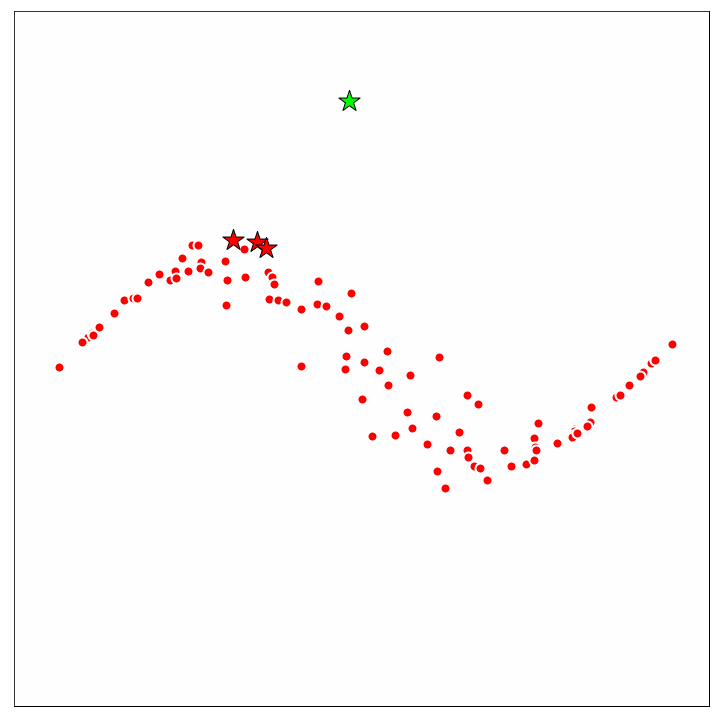

In [11]:
# green - visited balls
# number in vall center - order of visit
# yellow triangle - target point
# red square - nearest neighbor
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter([x[0]], [x[1]], marker='*', s=500, color='lime', zorder=1000, edgecolor='black')
ax.scatter(my_point[:,0], my_point[:,1], marker='*', s=500, color='red', zorder=1001, edgecolor='black')
my_bt.plot(animate=True, fig_ax=(fig, ax))